In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
df = pd.read_csv('dataset_politik_combined.csv')
df = df.drop_duplicates()
df = df.dropna()

In [23]:
df.head()

,full_text,processed_text_sastrawi,label
0,marah cawapres mentri yg jd cawapres menkopolh...,marah cawapres tri yg jd cawapres menkopolhukam,1
1,mahfud md resmi diumumkan cawapres ganjaar pra...,mahfud md resmi umum cawapres ganjaar pranowo ...,0
2,anakanak keberadaan cawapres prabowo gibran ra...,anakanak ada cawapres prabowo gibran rakabumin...,1
3,kalo tdk knp gerombolan pecundang spt diam beg...,kalo tdk knp gerombol cundang spt diam bego pu...,1
4,klo kiat rujuk dlu bg sajak jdi cawapres basan...,klo kiat rujuk dlu bg sajak jdi cawapres basan...,1


In [4]:
embedding_index = {}
with open('glove_50dim_wiki.id.case.text.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text_sastrawi'])
sequences = tokenizer.texts_to_sequences(df['processed_text_sastrawi'])

max_length = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_length)
y = df['label']  
y = to_categorical(y)

# Membagi dataset menjadi data latih dan data uji
X_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

embedding_dim = 50  # Sesuai dengan GloVe yang Anda gunakan
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    validation_data=(x_test, y_test))

Found 370013 word vectors.


Epoch 1/10


366/366 [==============================] - 15s 29ms/step - loss: 0.6704 - accuracy: 0.7115 - val_loss: 0.5905 - val_accuracy: 0.7497
Epoch 2/10
366/366 [==============================] - 10s 27ms/step - loss: 0.5721 - accuracy: 0.7598 - val_loss: 0.5610 - val_accuracy: 0.7631
Epoch 3/10
366/366 [==============================] - 9s 26ms/step - loss: 0.5366 - accuracy: 0.7746 - val_loss: 0.5159 - val_accuracy: 0.7785
Epoch 4/10
366/366 [==============================] - 10s 26ms/step - loss: 0.5060 - accuracy: 0.7886 - val_loss: 0.5538 - val_accuracy: 0.7836
Epoch 5/10
366/366 [==============================] - 9s 26ms/step - loss: 0.4750 - accuracy: 0.7988 - val_loss: 0.4943 - val_accuracy: 0.7887
Epoch 6/10
366/366 [==============================] - 10s 26ms/step - loss: 0.4427 - accuracy: 0.8165 - val_loss: 0.5073 - val_accuracy: 0.7856
Epoch 7/10
366/366 [==============================] - 10s 27ms/step - loss: 0.4152 - accuracy: 0.8265 - val

In [5]:
loss, accuracy = model.evaluate(x_test, y_test)

31/31 [==============================] - 0s 12ms/step - loss: 0.4935 - accuracy: 0.7846


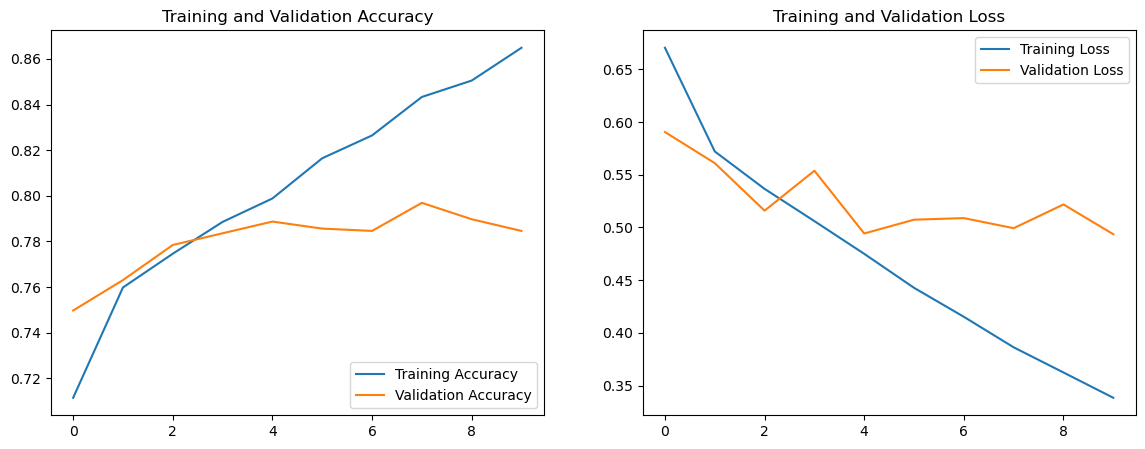

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)  # Adjust to match the number of epochs (10) in your training

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:10], label='Training Accuracy')  # Use [:10] to match the number of epochs
plt.plot(epochs_range, val_acc[:10], label='Validation Accuracy')  # Use [:10] to match the number of epochs
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[:10], label='Training Loss')  # Use [:10] to match the number of epochs
plt.plot(epochs_range, val_loss[:10], label='Validation Loss')  # Use [:10] to match the number of epochs
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [7]:
model.save('modelling6_deeplearning.h5')

c:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 13ms/step

Here is the classification report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       290
           1       0.90      0.88      0.89       372
           2       0.86      0.86      0.86       313

    accuracy                           0.87       975
   macro avg       0.87      0.87      0.87       975
weighted avg       0.87      0.87      0.87       975



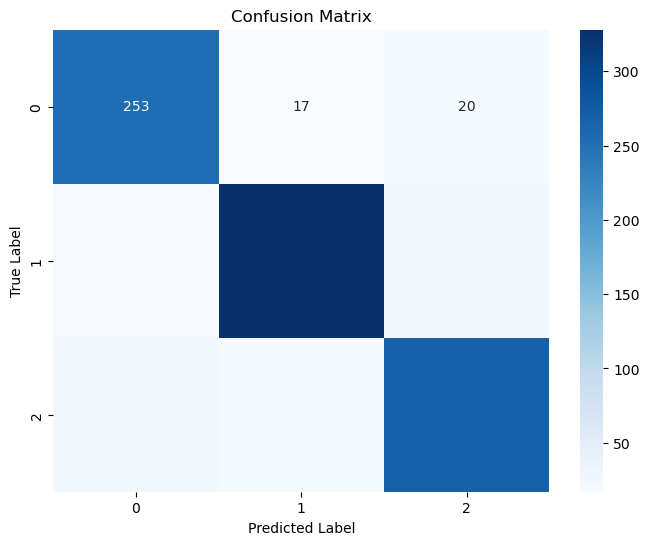

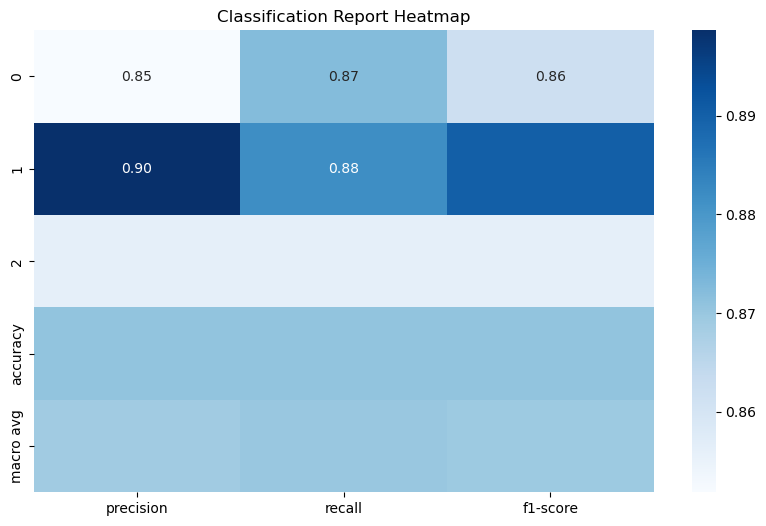

In [22]:
# Get raw predictions from the model
raw_predictions = model.predict(x_test)

# Convert raw predictions to class labels
predictions = np.argmax(raw_predictions, axis=1)

# Convert one-hot encoded y_test to class labels
true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
class_report = classification_report(true_labels, predictions, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("\nHere is the classification report:") 
print(classification_report(true_labels, predictions))

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize the Classification Report
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

In [19]:
print(predictions.shape)  # Should also be something like (n_samples,)


(975, 3)
